# 네이버 영화리뷰 데이터 감성분석

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf
import os

In [3]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [26]:
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [7]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [8]:
def load_data(train_data, test_data, num_words=10000):
    # drop duplicates
    print(f"length of train_data before dropping duplicates: {len(train_data)}")
    print(f"length of test_data before dropping duplicates: {len(test_data)}")

    train_data.drop_duplicates(inplace=True)
    test_data.drop_duplicates(inplace=True)

    print(f"length of train_data after dropping duplicates: {len(train_data)}")
    print(f"length of test_data after dropping duplicates: {len(test_data)}")

    train_data.dropna(inplace=True) # dropna 하지 않으면 토크나이저 오류가 발생
    test_data.dropna(inplace=True)

    print(f"length of train_data after dropping duplicates: {len(train_data)}")
    print(f"length of test_data after dropping duplicates: {len(test_data)}")

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)    

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

    word_to_index = {word:index for index, word in enumerate(vocab)}
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    label_column = "label"
    y_train = train_data.loc[:,label_column]
    print(X_train[:10])
    display(y_train.head())

    y_test = test_data.loc[:,label_column]
    print(X_test[:10])
    display(y_test.head())

    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

length of train_data before dropping duplicates: 150000
length of test_data before dropping duplicates: 50000
length of train_data after dropping duplicates: 150000
length of test_data after dropping duplicates: 50000
length of train_data after dropping duplicates: 149995
length of test_data after dropping duplicates: 49997
[[32, 74, 921, 4, 4, 39, 230, 20, 33, 752], [1022, 4, 11, 520, 549, 686, 5, 120, 4, 70, 1643, 52, 926, 1010, 15, 44, 391], [24, 205, 2], [8428, 159, 3935, 4, 4, 298, 93, 17, 6, 4, 4, 58, 3485], [2, 8913, 1108, 52, 2839, 61, 5, 14, 2766, 41, 1193, 35, 352, 42, 22, 40, 61, 2, 2, 429, 3104, 1771, 6], [676, 2, 2, 131, 420, 185, 1554, 715, 64, 1699, 706, 53, 376, 193, 268, 5, 4, 69, 4, 11, 2164, 122, 743, 4], [255, 382, 9, 385, 2013, 56, 15, 819, 6, 4], [235, 1458, 141, 6, 426, 756, 2, 2, 52, 1537, 290, 99, 252, 4, 4, 28, 857, 29, 353, 655, 542, 509, 585, 6, 3327, 4, 8914, 22, 1463, 1463, 4, 4, 71, 304, 17, 6, 52, 106, 8, 77, 22, 2, 43], [129, 17, 23, 93, 16, 290, 27, 48

0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

[[731, 130], [2], [85, 111, 58, 4, 70, 956, 332, 44, 38, 101, 36, 642, 3566, 73, 915], [95, 8, 15, 44, 231, 135, 357, 128, 4, 11, 154, 55, 7, 10, 42, 4, 70], [131, 1118, 22, 73, 21, 460, 235, 2143, 122, 552, 9, 595, 4, 4, 63, 131, 1118, 29, 636, 346, 2, 846, 8, 12, 8, 295, 18, 18], [238, 55, 161, 13, 54, 238, 5], [634, 104], [1098, 452, 593, 41, 2, 78, 4928, 1781, 17, 1551, 4307, 185, 13, 5735, 2948, 12, 198], [565, 1282, 48, 685, 5, 236, 8, 7, 89, 17, 30, 2998, 493, 6, 126, 123, 51, 27, 48, 2967, 236, 1212, 2, 32, 1413, 6, 2, 37, 5, 127, 131, 477, 1582, 318, 6], [2980, 1460, 615, 2, 826, 3120, 4033, 7494, 13, 277, 77, 336, 15, 44, 43, 4, 4]]


0    1
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [66]:
# Display train/test examples
train_data['document'] = train_data['document'].map(lambda x: tokenizer.morphs(x))
test_data['document'] = test_data['document'].map(lambda x:tokenizer.morphs(x))
train_data['document'] = train_data['document'].map(lambda x:' '.join([word for word in x if x not in stopwords]))
test_data['document'] = test_data['document'].map(lambda x:' '.join([word for word in x if x not in stopwords]))

In [67]:
vocab_size = 10000
word_vector_dim = 16    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 
embedding_test = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)
# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 

In [68]:
display(train_data['document'].iloc[:3])
example_raw_inputs = np.array(get_encoded_sentences(train_data['document'].iloc[:3], word_to_index), dtype=object)
print(example_raw_inputs)
example_raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(example_raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=20)

output = embedding_test(example_raw_inputs)
print(output)

0                            아 더 빙 . . 진짜 짜증 나 네요 목소리
1    흠 . .. 포스터 보고 초딩 영화 줄 . . .. 오버 연기 조 차 가볍 지 않 구나
2                                 너무 재 밓었다그래서보는것을추천한다
Name: document, dtype: object

[list([1, 32, 74, 921, 4, 4, 39, 230, 20, 33, 752])
 list([1, 1022, 4, 11, 520, 549, 686, 5, 120, 4, 4, 11, 1643, 52, 872, 747, 1010, 15, 44, 391])
 list([1, 24, 205, 2])]
tf.Tensor(
[[[ 4.64203469e-02  4.12863530e-02  4.87330891e-02 -3.70522253e-02
    4.56302240e-03  4.05508392e-02 -3.28563936e-02  4.77402546e-02
   -1.20607615e-02  4.87924330e-02 -6.73720986e-03 -4.78799604e-02
    3.67267616e-02 -3.92061695e-02 -4.24960628e-02  9.24787670e-03]
  [ 4.64203469e-02  4.12863530e-02  4.87330891e-02 -3.70522253e-02
    4.56302240e-03  4.05508392e-02 -3.28563936e-02  4.77402546e-02
   -1.20607615e-02  4.87924330e-02 -6.73720986e-03 -4.78799604e-02
    3.67267616e-02 -3.92061695e-02 -4.24960628e-02  9.24787670e-03]
  [ 4.64203469e-02  4.12863530e-02  4.87330891e-02 -3.70522253e-02
    4.56302240e-03  4.05508392e-02 -3.28563936e-02  4.77402546e-02
   -1.20607615e-02  4.87924330e-02 -6.73720986e-03 -4.78799604e-02
    3.67267616e-02 -3.92061695e-02 -4.24960628e-02  9.24787670e-03]
  [ 4.6420

In [15]:
get_decoded_sentences(example_raw_inputs, index_to_word)

['<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <BOS> 아 더 빙 . . 진짜 짜증 나 네요 목소리',
 '<PAD> <BOS> 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나',
 '<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <BOS> 너무 재 <UNK>']

In [58]:
# Maxlen 설정값
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens) # +표준편차*2.5 범위에서 95% 를 포함하게 됨
# max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.65940637625505
문장길이 최대 :  116
문장길이 표준편차 :  12.859527414389605
pad_sequences maxlen :  47
전체 문장의 0.953268130725229%가 maxlen 설정값 이내에 포함됩니다. 


# LSTM models

## LSTM 1: Singledirectional LSTM, post-padded data, Batchnorm
(test) loss: 1.7391 - accuracy: 0.4989


In [59]:
# sequence padding 
# [post] / [pre] 중 선택
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(149995, 47)


In [60]:
sample_idx = 105
sample = x_train[sample_idx]

print(get_decoded_sentence(sample, index_to_word))
print(y_train[sample_idx])

속 억지 스럽 고 노골 적 인 술 광고 은은 하 고 센스 있 게 했 으면 어땠 을까 ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
0


In [61]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 47)
(109995,)


In [62]:
def get_model():
    vocab_size = 10000   # 어휘 사전의 크기입니다(10개의 단어)
    word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

    model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(32))   

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

model = get_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         74240     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)         

In [63]:

type(partial_y_train)
partial_y_train.value_counts()

0    55161
1    54834
Name: label, dtype: int64

In [64]:
class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))

In [65]:
learning_rate =0.005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[ConfusionHistory()],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 10s 27ms/step - loss: 0.7060 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5002
train confusion matrix on epoch 0
[[55161     0]
 [54834     0]]
val confusion matrix on epoch 0
[[20009     0]
 [19991     0]]
Epoch 2/20
215/215 [==============================] - 5s 23ms/step - loss: 0.6946 - accuracy: 0.5028 - val_loss: 0.7368 - val_accuracy: 0.5002
train confusion matrix on epoch 1
[[55161     0]
 [54834     0]]
val confusion matrix on epoch 1
[[20009     0]
 [19991     0]]
Epoch 3/20
215/215 [==============================] - 5s 23ms/step - loss: 0.4294 - accuracy: 0.7861 - val_loss: 1.6373 - val_accuracy: 0.5002
train confusion matrix on epoch 2
[[55158     3]
 [54830     4]]
val confusion matrix on epoch 2
[[20009     0]
 [19991     0]]
Epoch 4/20
215/215 [==============================] - 5s 23ms/step - loss: 0.3094 - accuracy: 0.8675 - val_loss: 3.0178 - val_accuracy: 0.5117
train confusion matrix on epoch 3
[[ 1243 5

In [69]:
def evaluate_model(model):
    results = model.evaluate(x_test,  y_test, verbose=2)
    print(results)
    y_test_pred_probs = model.predict(x_test)
    partial_y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten() 
    print("test confusion matrix")
    print(confusion_matrix(y_test, partial_y_test_pred ))
    history_dict = history.history
    print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1,2, figsize=(20,5))
    # "bo"는 "파란색 점"입니다
    ax[0].plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc, 'bo', label='Training acc')
    ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

1563/1563 - 6s - loss: 0.7861 - accuracy: 0.8256
[0.7860750555992126, 0.8256495594978333]
test confusion matrix
[[21125  3701]
 [ 5016 20155]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


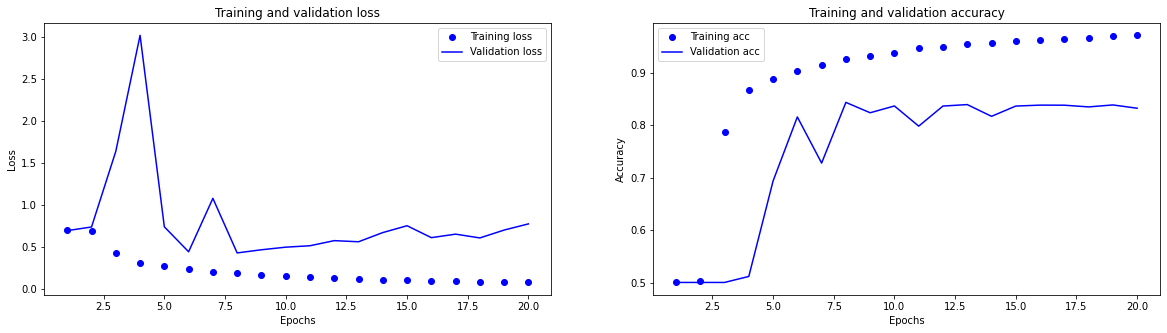

In [70]:
evaluate_model(model)

In [113]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


## LSTM 2: Singledirectional LSTM, pre-padded data, Batchnorm
(test) loss: 0.6455 - accuracy: 0.8327

In [63]:

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 143)


In [64]:
sample_idx = 105
sample = x_train[sample_idx]

print(get_decoded_sentence(sample, index_to_word))
print(y_train[sample_idx])

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 영화 속 억지 스럽 고 노골 적 인 술 광고 은은 하 고 센스 있 게 했 으면 어땠 을까 ?
0


In [65]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 143)
(109995,)


In [66]:
def get_model():
    vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
    word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

    model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(32))   

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

model_2 = get_model()

class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_2.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_2.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 128)         74240     
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 128)         512       
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
batch_normalization_21 (Batc (None, None, 64)          256       
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 64)         

In [67]:
learning_rate =0.005
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[ConfusionHistory()],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 18s 66ms/step - loss: 0.4386 - accuracy: 0.7831 - val_loss: 0.5959 - val_accuracy: 0.6476
train confusion matrix on epoch 0
[[54843   318]
 [37752 17082]]
val confusion matrix on epoch 0
[[19864   145]
 [13952  6039]]
Epoch 2/20
215/215 [==============================] - 13s 62ms/step - loss: 0.3129 - accuracy: 0.8649 - val_loss: 1.2712 - val_accuracy: 0.5002
train confusion matrix on epoch 1
[[55161     0]
 [54834     0]]
val confusion matrix on epoch 1
[[20009     0]
 [19991     0]]
Epoch 3/20
215/215 [==============================] - 13s 61ms/step - loss: 0.2783 - accuracy: 0.8803 - val_loss: 1.3493 - val_accuracy: 0.5189
train confusion matrix on epoch 2
[[55140    21]
 [52836  1998]]
val confusion matrix on epoch 2
[[20001     8]
 [19237   754]]
Epoch 4/20
215/215 [==============================] - 13s 62ms/step - loss: 0.2510 - accuracy: 0.8932 - val_loss: 1.5652 - val_accuracy: 0.5715
train confusion matrix on epoch 3
[[5469

1563/1563 - 10s - loss: 0.6455 - accuracy: 0.8327
[0.6454634666442871, 0.8326699733734131]
test confusion matrix
[[20253  4573]
 [ 3793 21378]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


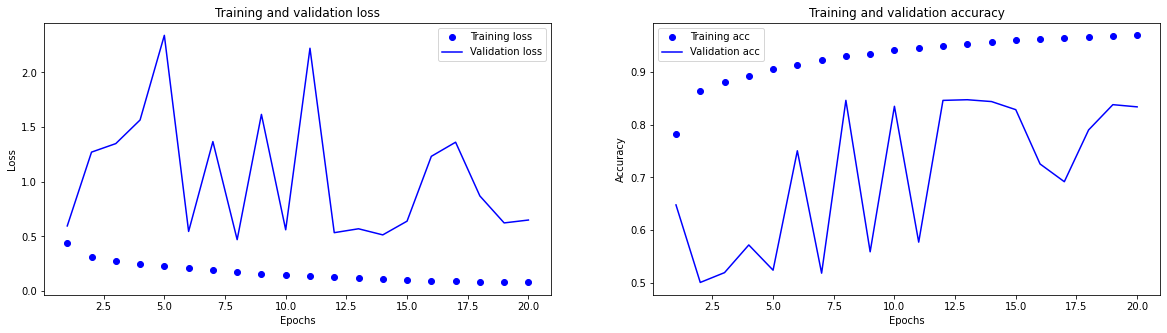

In [68]:
evaluate_model(model_2)

## LSTM 3: Smaller singledirectional LSTM, pre-padded data, NO Batchnorm
(test) loss: 0.8130 - accuracy: 0.8340

In [73]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 143)


In [74]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 143)
(109995,)


In [75]:
def get_model():
    vocab_size = 10000   # 어휘 사전의 크기입니다(10개의 단어)
    word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
    model.add(tf.keras.layers.LSTM(8))
    model.add(tf.keras.layers.Dense(8,activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.summary()
    return model

model_3 = get_model()

class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_3.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_3.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [76]:
learning_rate =0.005
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[ConfusionHistory()],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 5s 11ms/step - loss: 0.4266 - accuracy: 0.8039 - val_loss: 0.3532 - val_accuracy: 0.8466
train confusion matrix on epoch 0
[[50605  4556]
 [ 9740 45094]]
val confusion matrix on epoch 0
[[17919  2090]
 [ 4046 15945]]
Epoch 2/20
215/215 [==============================] - 2s 9ms/step - loss: 0.3159 - accuracy: 0.8670 - val_loss: 0.3350 - val_accuracy: 0.8535
train confusion matrix on epoch 1
[[49802  5359]
 [ 6704 48130]]
val confusion matrix on epoch 1
[[17280  2729]
 [ 3132 16859]]
Epoch 3/20
215/215 [==============================] - 2s 9ms/step - loss: 0.2774 - accuracy: 0.8845 - val_loss: 0.3360 - val_accuracy: 0.8563
train confusion matrix on epoch 2
[[51715  3446]
 [ 6976 47858]]
val confusion matrix on epoch 2
[[17869  2140]
 [ 3607 16384]]
Epoch 4/20
215/215 [==============================] - 2s 9ms/step - loss: 0.2442 - accuracy: 0.8991 - val_loss: 0.3416 - val_accuracy: 0.8586
train confusion matrix on epoch 3
[[50811  4350

1563/1563 - 4s - loss: 0.8130 - accuracy: 0.8340
[0.8130459189414978, 0.8339700102806091]
test confusion matrix
[[20719  4107]
 [ 4194 20977]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


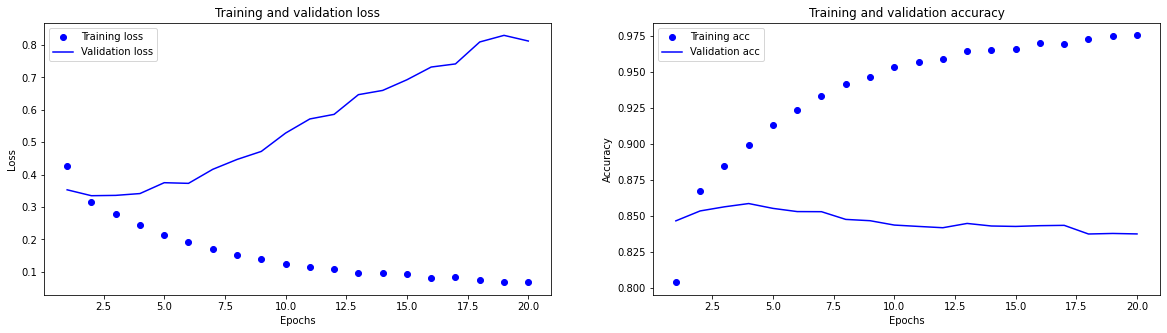

In [77]:
evaluate_model(model_3)

In [114]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## LSTM 4: Smaller singledirectional LSTM, post-padded data, NO Batchnorm
(test) loss: 0.6933 - accuracy: 0.4965

In [78]:

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 143)


In [79]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 143)
(109995,)


In [80]:
model_4 = get_model()

class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_4.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_4.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [81]:
learning_rate =0.005
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[ConfusionHistory()],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 4s 11ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 2/20
215/215 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/20
215/215 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 4/20
215/215 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 5/20
215/215 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 6/20
215/215 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 7/20
215/215 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch

1563/1563 - 4s - loss: 0.6933 - accuracy: 0.4965
[0.6932516694068909, 0.4965497851371765]
test confusion matrix
[[24826     0]
 [25171     0]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


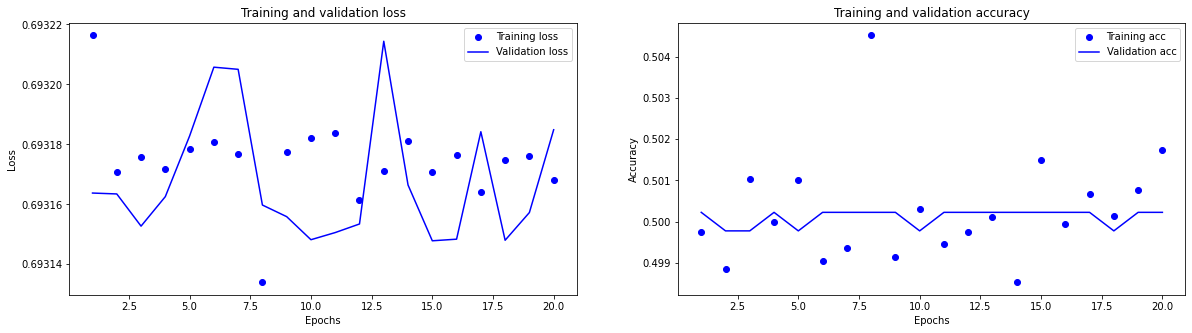

In [82]:
evaluate_model(model_4)

## LSTM 5: Smaller bidirectional LSTM, post-padded data, NO Batchnorm
(test) loss: 0.4843 - accuracy: 0.8162

In [32]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 142)


In [33]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 142)
(109995,)


In [52]:
def get_model():
    vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
    word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
    model.add(tf.keras.layers.Dense(8,activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.summary()
    return model

model_bid = get_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 161,745
Trainable params: 161,745
Non-trainable params: 0
_________________________________________________________________


In [53]:
class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_bid.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_bid.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))

In [54]:
learning_rate =0.005
model_bid.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_bid.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 7s 18ms/step - loss: 0.4636 - accuracy: 0.7930 - val_loss: 0.3592 - val_accuracy: 0.8453
Epoch 2/20
215/215 [==============================] - 3s 14ms/step - loss: 0.3179 - accuracy: 0.8652 - val_loss: 0.3361 - val_accuracy: 0.8557
Epoch 3/20
215/215 [==============================] - 3s 14ms/step - loss: 0.2807 - accuracy: 0.8816 - val_loss: 0.3325 - val_accuracy: 0.8565
Epoch 4/20
215/215 [==============================] - 3s 15ms/step - loss: 0.2528 - accuracy: 0.8941 - val_loss: 0.3437 - val_accuracy: 0.8574
Epoch 5/20
215/215 [==============================] - 3s 14ms/step - loss: 0.2281 - accuracy: 0.9061 - val_loss: 0.3607 - val_accuracy: 0.8562
Epoch 6/20
215/215 [==============================] - 3s 14ms/step - loss: 0.2075 - accuracy: 0.9146 - val_loss: 0.3815 - val_accuracy: 0.8536
Epoch 7/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1910 - accuracy: 0.9216 - val_loss: 0.3958 - val_accuracy: 0.8522

1563/1563 - 6s - loss: 0.6881 - accuracy: 0.8224
[0.6880972981452942, 0.8223893642425537]
test confusion matrix
[[20309  4517]
 [ 4363 20808]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


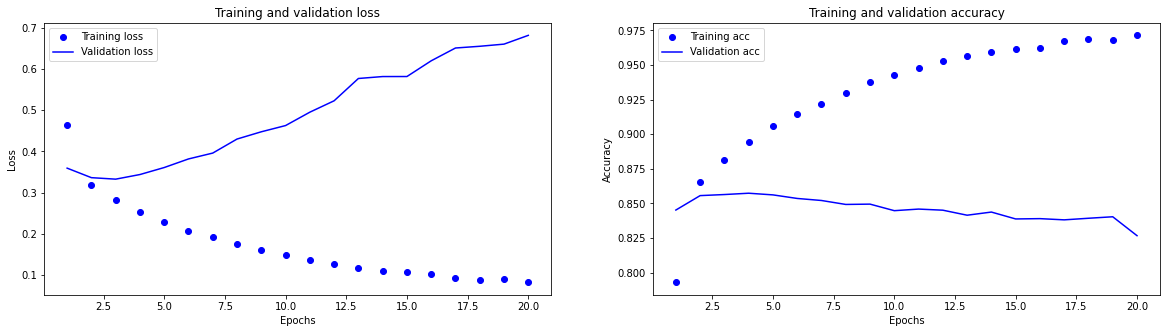

In [55]:
evaluate_model(model_bid)

## CNN 1: pre-padded data, 
(test) loss: 1.4108 - accuracy: 0.7440

In [87]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 143)


In [88]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 143)
(109995,)


In [89]:
def get_model():
    vocab_size = 10000   # 어휘 사전의 크기입니다(10개의 단어)
    word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.Conv1D(512, 7, activation='relu'))
    model.add(tf.keras.layers.Conv1D(512, 7, activation='relu'))
    model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
    model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))

    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))

    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

model_5 = get_model()

class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_5.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_5.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 512)         57856     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 512)         1835520   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          229440    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)        

In [92]:
learning_rate =0.005
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_5.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[ConfusionHistory()],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 47s 215ms/step - loss: 0.4274 - accuracy: 0.7825 - val_loss: 0.4509 - val_accuracy: 0.7656
train confusion matrix on epoch 0
[[48015  7146]
 [13436 41398]]
val confusion matrix on epoch 0
[[16542  3467]
 [ 5907 14084]]
Epoch 2/20
215/215 [==============================] - 46s 212ms/step - loss: 0.3838 - accuracy: 0.8055 - val_loss: 0.4625 - val_accuracy: 0.7638
train confusion matrix on epoch 1
[[49469  5692]
 [12552 42282]]
val confusion matrix on epoch 1
[[16602  3407]
 [ 6040 13951]]
Epoch 3/20
215/215 [==============================] - 46s 213ms/step - loss: 0.3433 - accuracy: 0.8277 - val_loss: 0.4943 - val_accuracy: 0.7585
train confusion matrix on epoch 2
[[49012  6149]
 [10516 44318]]
val confusion matrix on epoch 2
[[15785  4224]
 [ 5436 14555]]
Epoch 4/20
215/215 [==============================] - 46s 213ms/step - loss: 0.3083 - accuracy: 0.8441 - val_loss: 0.5412 - val_accuracy: 0.7597
train confusion matrix on epoch 3
[[

1563/1563 - 8s - loss: 1.4108 - accuracy: 0.7440
[1.4107531309127808, 0.7439646124839783]
test confusion matrix
[[17722  7104]
 [ 5697 19474]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


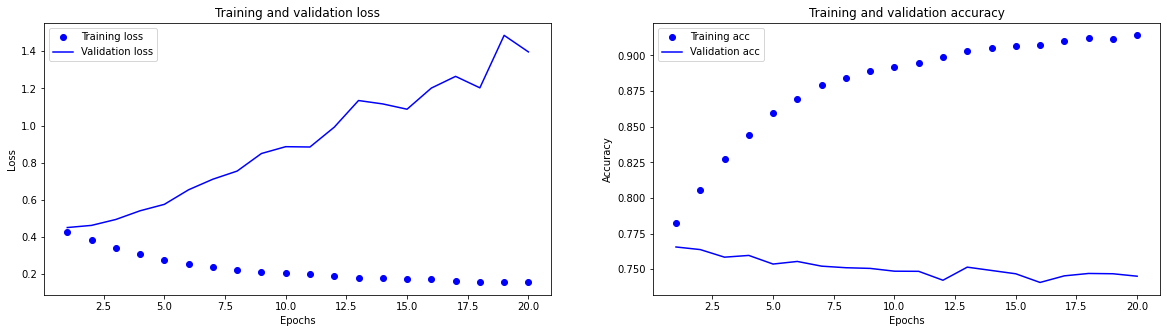

In [93]:
evaluate_model(model_5)

## CNN 2 : post-padded data
(test)loss: 1.2801 - accuracy: 0.8301

In [94]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 143)


In [95]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 143)
(109995,)


In [96]:
model_6 = get_model()

class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_6.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_6.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 512)         57856     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 512)         1835520   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 64)          229440    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 16)        

In [97]:
learning_rate =0.005
model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_6.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks=[ConfusionHistory()],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 47s 216ms/step - loss: 0.4332 - accuracy: 0.7886 - val_loss: 0.3410 - val_accuracy: 0.8500
train confusion matrix on epoch 0
[[48805  6356]
 [ 7581 47253]]
val confusion matrix on epoch 0
[[17318  2691]
 [ 3308 16683]]
Epoch 2/20
215/215 [==============================] - 46s 215ms/step - loss: 0.3113 - accuracy: 0.8672 - val_loss: 0.3320 - val_accuracy: 0.8546
train confusion matrix on epoch 1
[[49722  5439]
 [ 5752 49082]]
val confusion matrix on epoch 1
[[17160  2849]
 [ 2967 17024]]
Epoch 3/20
215/215 [==============================] - 46s 214ms/step - loss: 0.2670 - accuracy: 0.8879 - val_loss: 0.3418 - val_accuracy: 0.8557
train confusion matrix on epoch 2
[[52108  3053]
 [ 6344 48490]]
val confusion matrix on epoch 2
[[17881  2128]
 [ 3644 16347]]
Epoch 4/20
215/215 [==============================] - 46s 214ms/step - loss: 0.2262 - accuracy: 0.9071 - val_loss: 0.3822 - val_accuracy: 0.8515
train confusion matrix on epoch 3
[[

1563/1563 - 8s - loss: 1.2801 - accuracy: 0.8301
[1.2800836563110352, 0.8301498293876648]
test confusion matrix
[[20592  4234]
 [ 4258 20913]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


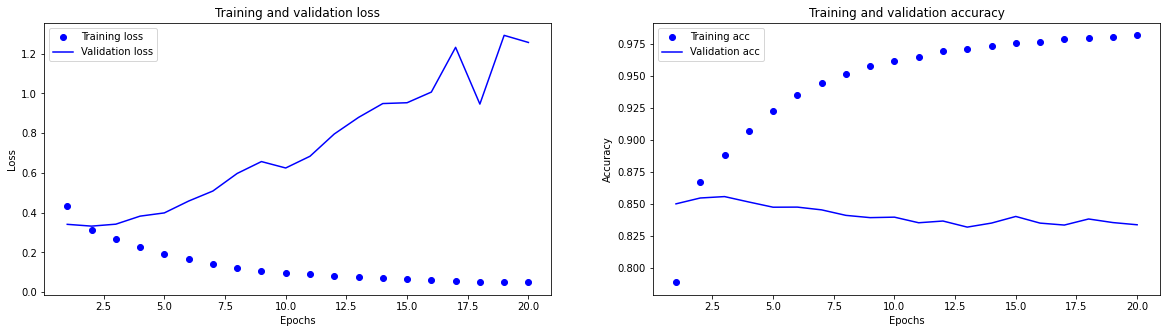

In [98]:
evaluate_model(model_6)

# Dense(Feedforward network)
pre: (test)loss: 0.5262 - accuracy: 0.8256  
post: (test)loss: 0.5339 - accuracy: 0.8258

In [71]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)

(149995, 47)


In [72]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(109995, 47)
(109995,)


In [74]:
def get_model():
    vocab_size = 10000   # 어휘 사전의 크기입니다(10개의 단어)
    word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 


    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

model_7 = get_model()

class ConfusionHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        pass
    def on_batch_end(self, batch, logs):
        pass
    def on_epoch_end(self, epoch, logs):
        partial_y_train_pred_probs = model_7.predict(partial_x_train)
        partial_y_train_pred = (partial_y_train_pred_probs > 0.5).astype(int).flatten() 
        print(f"train confusion matrix on epoch {epoch}")
        print(confusion_matrix(partial_y_train, partial_y_train_pred))

        y_val_pred_probs = model_7.predict(x_val)
        partial_y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        print(f"val confusion matrix on epoch {epoch}")
        print(confusion_matrix(y_val, partial_y_val_pred ))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [75]:
model_7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_7.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 0.6008 - accuracy: 0.7553 - val_loss: 0.4476 - val_accuracy: 0.8177
Epoch 2/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3863 - accuracy: 0.8363 - val_loss: 0.3651 - val_accuracy: 0.8383
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3314 - accuracy: 0.8601 - val_loss: 0.3515 - val_accuracy: 0.8450
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3024 - accuracy: 0.8745 - val_loss: 0.3490 - val_accuracy: 0.8470
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2810 - accuracy: 0.8845 - val_loss: 0.3519 - val_accuracy: 0.8482
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2637 - accuracy: 0.8932 - val_loss: 0.3571 - val_accuracy: 0.8464
Epoch 7/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2489 - accuracy: 0.8995 - val_loss: 0.3649 - val_accuracy: 0.8460
Epoch 

1563/1563 - 2s - loss: 0.5190 - accuracy: 0.8253
[0.5190017819404602, 0.8253495097160339]
test confusion matrix
[[20540  4286]
 [ 4446 20725]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


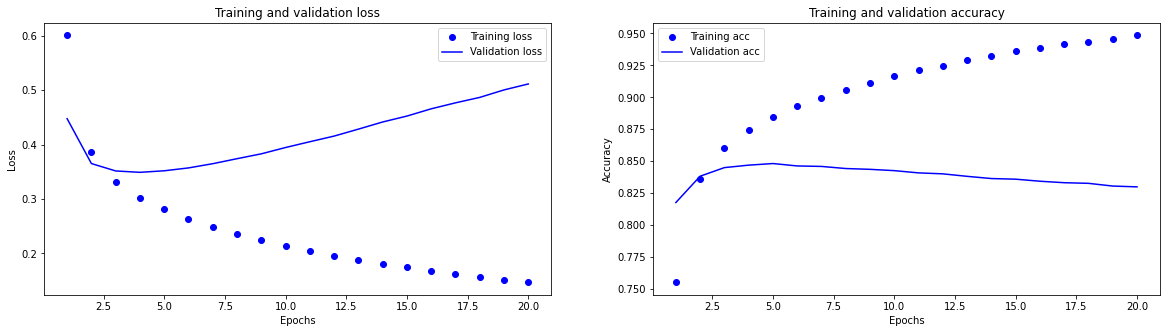

In [76]:
evaluate_model(model_7)

In [77]:
embedding_layer = model_bid.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

word2vec_file_path_model_bid = './data/word2vec_model_bid.txt'
f = open(word2vec_file_path_model_bid, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_bid.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


# Gensim word2vec

In [79]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_model_bid = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_model_bid, binary=False)

vector = word_vectors_model_bid['의문']
vector

array([-0.24819195,  0.4917998 ,  0.2551431 , -0.01746689,  0.5776546 ,
        0.21187468, -0.03412189, -0.4275546 ,  0.08029493,  0.36467454,
       -0.07998908,  0.11912448,  0.07334579, -0.11456662,  0.22010204,
       -0.09924691], dtype=float32)

In [80]:
word_vectors_model_bid.similar_by_word("의문")

[('칼싸움', 0.8307280540466309),
 ('창고', 0.8117814064025879),
 ('가두', 0.7929912805557251),
 ('심심', 0.7702180743217468),
 ('혈압', 0.7653786540031433),
 ('벗', 0.7639997005462646),
 ('끼리', 0.7601163387298584),
 ('에드워드', 0.7597247958183289),
 ('부처', 0.7579050660133362),
 ('못하', 0.7527246475219727)]

In [92]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_model_path = './data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_model_path).wv
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.key_to_index:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

In [95]:
from tensorflow.keras.initializers import Constant


def get_model():
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=False))   # trainable을 True로 주면 Fine-tuning

    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

model_emb = get_model()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 47, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 817
Non-trainable params: 1,000,000
_________________________________________________________________


In [96]:
# 학습의 진행
model_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_emb.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 1s 3ms/step - loss: 0.7190 - accuracy: 0.5492 - val_loss: 0.6670 - val_accuracy: 0.5965
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 0.6478 - accuracy: 0.6201 - val_loss: 0.6360 - val_accuracy: 0.6352
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 0.6278 - accuracy: 0.6467 - val_loss: 0.6215 - val_accuracy: 0.6551
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 0.6190 - accuracy: 0.6582 - val_loss: 0.6141 - val_accuracy: 0.6648
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 0.6140 - accuracy: 0.6631 - val_loss: 0.6126 - val_accuracy: 0.6630
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.6656 - val_loss: 0.6106 - val_accuracy: 0.6654
Epoch 7/20
215/215 [==============================] - 1s 3ms/step - loss: 0.6089 - accuracy: 0.6680 - val_loss: 0.6068 - val_accuracy: 0.6692
Epoch 

1563/1563 - 2s - loss: 0.6033 - accuracy: 0.6737
[0.6033252477645874, 0.6737204194068909]
test confusion matrix
[[16894  7932]
 [ 8381 16790]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


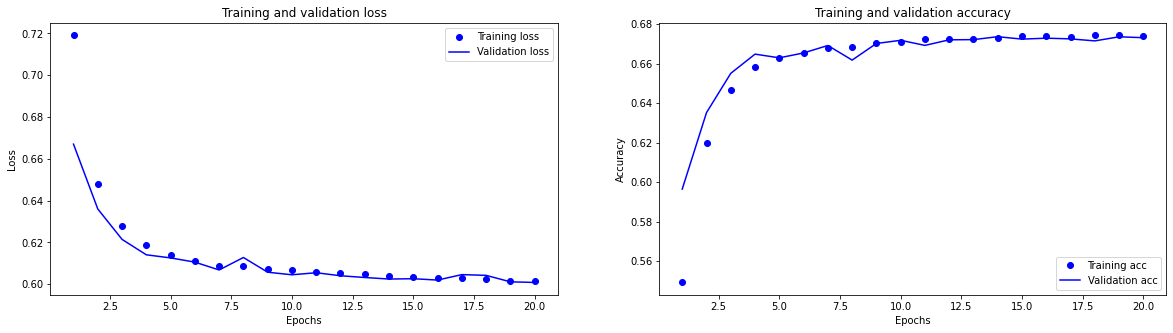

In [97]:
evaluate_model(model_emb)

In [99]:
def get_model():
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   

    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

model_emb_2 = get_model()

# 학습의 진행
model_emb_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30

history = model_emb_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 47, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
215/215 [==============================] - 1s 5ms/step - loss: 0.6890 - accuracy: 0.5533 - val_loss: 0.6643 - val_accuracy: 0.5985
Epoch 2/30
215/215 [==============================] - 1s 4ms/step - loss: 0.6331 - accuracy: 0.6417

1563/1563 - 2s - loss: 0.4247 - accuracy: 0.8122
[0.4247491955757141, 0.8121887445449829]
test confusion matrix
[[20567  4259]
 [ 5131 20040]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


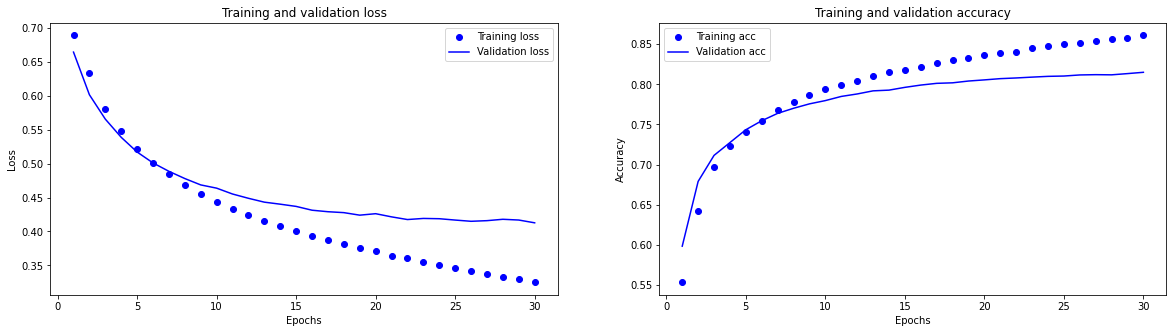

In [100]:
evaluate_model(model_emb_2)

In [102]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape)
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
def get_model():

    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   

    model.add(tf.keras.layers.LSTM(8))
    model.add(tf.keras.layers.Dense(8,activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.summary()
    return model

model_emb_lstm = get_model()

learning_rate =0.005
model_emb_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_emb_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

(149995, 47)
(109995, 47)
(109995,)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 47, 100)           1000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
215/215 [==============================] - 3s 8ms/step - loss: 0.4693 - accuracy: 0.7739 - val_loss: 0.3826 - val_accuracy: 0.8335
Epoch 2/20
215/215 [==============================] - 1s 7ms/st

1563/1563 - 3s - loss: 0.5193 - accuracy: 0.8279
[0.5193301439285278, 0.8278696537017822]
test confusion matrix
[[20479  4347]
 [ 4259 20912]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


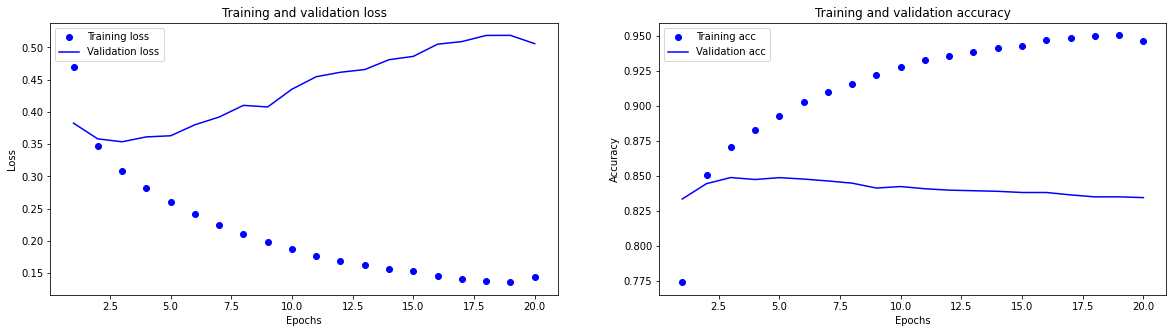

In [103]:
evaluate_model(model_emb_lstm)

In [153]:
def get_model():

    model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.summary()
    return model

model_emb_lstm_bid = get_model()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 47, 100)           1000000   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                34048     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
Total params: 1,036,289
Trainable params: 1,036,225
Non-trainable params: 64
__________________________________________

In [154]:
learning_rate =0.005
model_emb_lstm_bid.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=40  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_emb_lstm_bid.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
                    verbose=1)

Epoch 1/40
215/215 [==============================] - 5s 13ms/step - loss: 0.4647 - accuracy: 0.7764 - val_loss: 0.3604 - val_accuracy: 0.8425
Epoch 2/40
215/215 [==============================] - 2s 10ms/step - loss: 0.3369 - accuracy: 0.8549 - val_loss: 0.3401 - val_accuracy: 0.8519
Epoch 3/40
215/215 [==============================] - 2s 10ms/step - loss: 0.3001 - accuracy: 0.8736 - val_loss: 0.3352 - val_accuracy: 0.8565
Epoch 4/40
215/215 [==============================] - 2s 10ms/step - loss: 0.2720 - accuracy: 0.8869 - val_loss: 0.3397 - val_accuracy: 0.8569
Epoch 5/40
215/215 [==============================] - 2s 10ms/step - loss: 0.2501 - accuracy: 0.8968 - val_loss: 0.3483 - val_accuracy: 0.8536
Epoch 6/40
215/215 [==============================] - 2s 10ms/step - loss: 0.2303 - accuracy: 0.9069 - val_loss: 0.3644 - val_accuracy: 0.8569


1563/1563 - 4s - loss: 0.3708 - accuracy: 0.8514
[0.37076443433761597, 0.8513711094856262]
test confusion matrix
[[21960  2866]
 [ 4565 20606]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


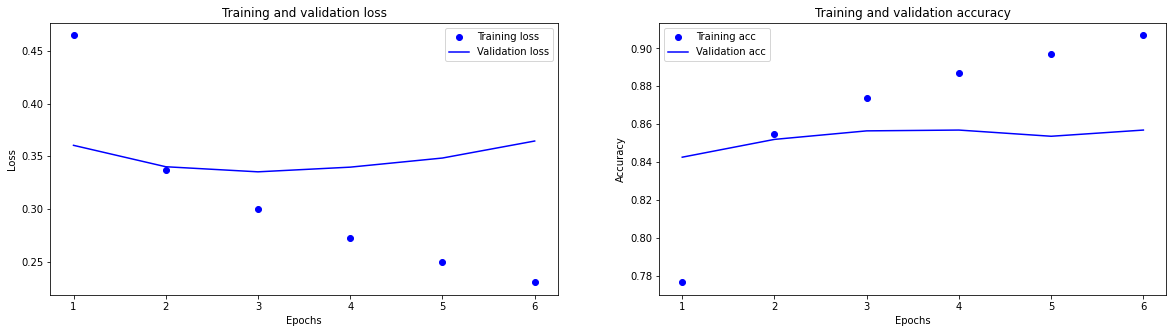

In [155]:
evaluate_model(model_emb_lstm_bid)

# 회고
- 단방향 LSTM의 문제 : 시퀀스에서 의미를 가진 부분의 위치가 시퀀스의 후반 타임스텝에 와야 학습이 가능하다.
    - 학습과정 중의 기울기 소실에 따른 장기의존성 학습 실패로 추정된다.
    - 패딩의 위치가 크게 중요하지 않은 양방향 LSTM에서의 성능(82%)은 post-padding 데이터에서도 높은 성능을 달성할 수 있지만, 
    - 성능면에서는 single LSTM에 pre-padding하는 것에 비하여 suboptimal한 선택으로 보였다(사전학습 임베딩 없이).
    - 그러나 사전학습 임베딩과 규제(Dropout) 등을 사용하고 Batchnorm을 섞는 등 여러 변경을 시도하였을 때, Bidirectional model을 이용하여 충분히 성능 향상을 달성할 수 있었다.(85%)  
- 그외 시도
    - pre-padding 단방향 LSTM의 기울기 소실 문제를 해결하기 위하여 Batchnorm 등을 시도하였다.
        - Batchnorm을 사용하지 않으면 val acc가 50%(balanced binary classification data이므로, 전혀 학습하지 못함)
        - 사용했을 때 val acc가 50~85 사이에서 진동한다.

- 아키텍처 변경의 필요성.
    - 1D CNN 아키텍처
        - 시퀀스 내에서의 패딩 위치에 영향이 덜하다(pre:75%, post:83%).
        - dense network(82%) 보다 약간의 성능 향상이 있다.
    - RNN에서의 이와 같은 장기 의존성 문제를 해결한 Transformer 등의 아키텍처 모델을 사용하는 것이 권장된다.
- 기타
    - tf에서는 실험에서 자주 바뀌는 설정들을 keras tuner를 이용해 관리할 수 있다.